# Secret Hitler Game Session Analysis

This notebook analyzes the game session logs generated by the LLM agents.

In [24]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [25]:
# Find the latest log file
log_files = glob.glob('logs/*.jsonl')
if not log_files:
    raise FileNotFoundError("No .jsonl log files found in logs/ directory.")
latest_log_file = max(log_files, key=os.path.getctime)
print(f"Analyzing log file: {latest_log_file}")

# Load data
data = []
with open(latest_log_file, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

# Create initial DataFrame
df = pd.DataFrame(data)

# Rename the original 'message' to 'raw_message' to avoid collision
if 'message' in df.columns:
    df.rename(columns={'message': 'raw_message'}, inplace=True)

# Normalize the 'data' column which contains structured game data
if 'data' in df.columns:
    # We use pd.json_normalize on the list of dicts to get a flat dataframe of the 'data' column
    data_df = pd.json_normalize(df['data'])
    # Concatenate with the original dataframe (dropping the original 'data' column)
    df = pd.concat([df.drop(['data'], axis=1), data_df], axis=1)

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Display first few rows and columns to verify
print("Columns:", df.columns.tolist())
df.head()

Analyzing log file: logs/game_session_20251203_193635.jsonl
Columns: ['timestamp', 'level', 'raw_message', 'type', 'message', 'event', 'player', 'thought', 'action', 'details', 'speech']


/tmp/ipykernel_113410/1197748818.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


,timestamp,level,raw_message,type,message,event,player,thought,action,details,speech
0,2025-12-03 19:36:37,INFO,[37m[SYSTEM][0m Game Setup Complete. Players...,system,"Game Setup Complete. Players: ['Alice', 'Bob',...",NaN,NaN,NaN,NaN,NaN,NaN
1,2025-12-03 19:36:37,INFO,[37m[SYSTEM][0m Roles (SECRET): {'Alice': 'L...,system,"Roles (SECRET): {'Alice': 'Loyalist', 'Bob': '...",NaN,NaN,NaN,NaN,NaN,NaN
2,2025-12-03 19:36:37,INFO,[37m[SYSTEM][0m Starting Game Session...,system,Starting Game Session...,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-12-03 19:36:37,INFO,[37m[SYSTEM][0m --- Round 1 ---,system,--- Round 1 ---,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-12-03 19:36:37,INFO,[33m[GAME][0m President is Alice,game_event,NaN,President is Alice,NaN,NaN,NaN,NaN,NaN


In [36]:
# Extract Game Info
try:
    # Check for Game Setup message
    # We check both the top-level 'message' (with ANSI) and the extracted 'message' (from data) if it exists.
    # Since we have duplicate column names potentially, let's look at the 'type' column.
    
    game_start_msgs = df[(df['type'] == 'system') & (df['message'].astype(str).str.contains("Game Setup Complete", na=False))]
    if not game_start_msgs.empty:
        print("Game Setup found.")
    
    # Check for Roles message
    # The roles are in a system message
    roles_msgs = df[(df['type'] == 'system') & (df['message'].astype(str).str.contains(r"Roles \(SECRET\)", na=False))]
    
    if not roles_msgs.empty:
        # We can try to parse the clean message from the 'data' part if available.
        # Since we concatenated, we might have multiple 'message' columns.
        # Let's iterate and find the one that looks like a dict string or just parse the text.
        
        # In the log: "Roles (SECRET): {'Alice': 'Loyalist', ...}"
        # We can regex extract the dict part.
        import re
        import ast
        
        roles_row = roles_msgs.iloc[0]
        # Join all string columns in the row to search for the pattern, just to be safe against column name collisions
        row_text = " ".join(roles_row.astype(str).values)
        
        match = re.search(r"Roles \(SECRET\): ({.+?})", row_text)
        if match:
            roles_str = match.group(1)
            try:
                roles = ast.literal_eval(roles_str)
                print("Game Roles:")
                for player, role in roles.items():
                    print(f"  {player}: {role}")

                # Add Role column to main dataframe for easier analysis
                # The 'player' column comes from the 'data' field.
                if 'player' in df.columns:
                    df['role'] = df['player'].map(roles)
                else:
                    print("Warning: 'player' column missing.")
            except (ValueError, SyntaxError):
                print(f"Error parsing roles string: {roles_str}")
        else:
            print("Roles pattern not found in the message.")
    else:
        print("Roles message not found in logs.")

    # Game Duration
    if 'timestamp' in df.columns and not df.empty:
        start_time = df['timestamp'].min()
        end_time = df['timestamp'].max()
        duration = end_time - start_time
        print(f"\nGame Duration: {duration}")
        
except Exception as e:
    print(f"An error occurred during game info extraction: {e}")
    import traceback
    traceback.print_exc()

Game Setup found.
Game Roles:
  Alice: Loyalist
  Bob: Loyalist
  Charlie: Master Spy
  David: Spy
  Eve: Loyalist

Game Duration: 0 days 00:27:59


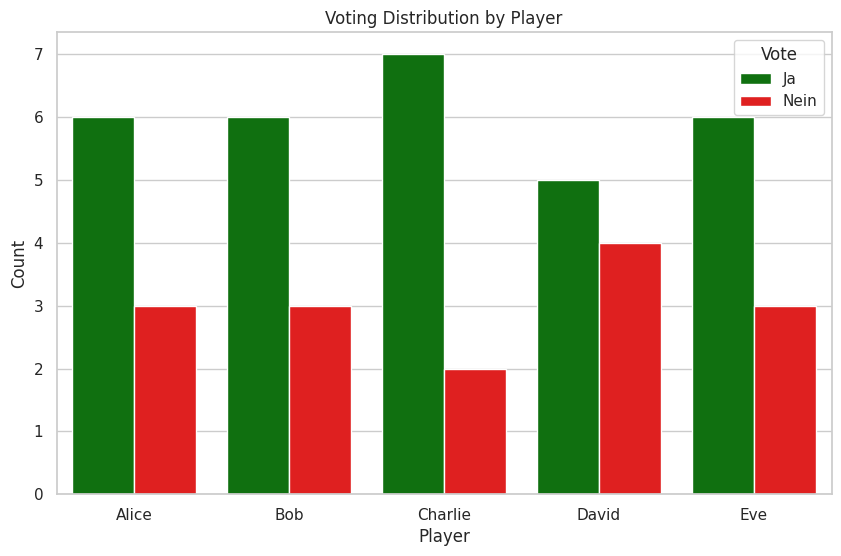

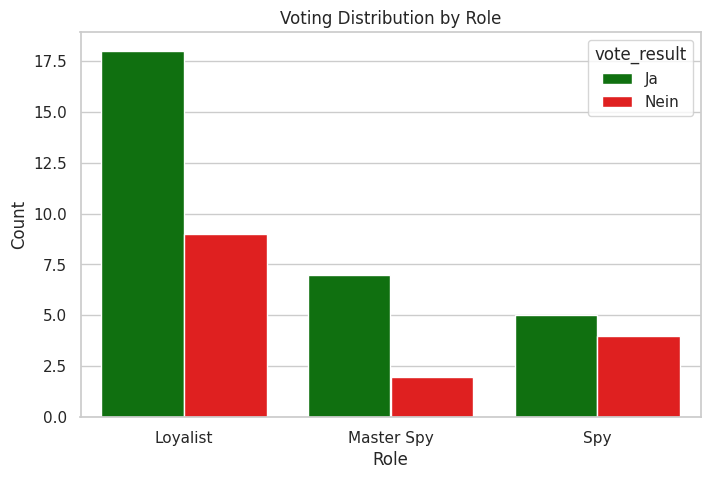

In [27]:
# Voting Analysis
votes_df = pd.DataFrame()

# Ensure we have the basic columns
# We expect 'player', 'action', 'details' from the normalized data
if 'player' in df.columns and 'action' in df.columns:
    # Filter for voting actions
    # Log format: type="action", data={"player": "...", "action": "Voted", "details": "Ja"}
    
    vote_mask = (df['type'] == 'action') & (df['action'] == 'Voted')
    votes_df = df[vote_mask].copy()
    
    if not votes_df.empty:
        # The vote result is in the 'details' column
        votes_df['vote_result'] = votes_df['details']
            
        # Drop rows where vote_result is NaN (if any)
        votes_df = votes_df.dropna(subset=['vote_result'])

        if not votes_df.empty:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=votes_df, x='player', hue='vote_result', palette={'Ja': 'green', 'Nein': 'red'})
            plt.title('Voting Distribution by Player')
            plt.xlabel('Player')
            plt.ylabel('Count')
            plt.legend(title='Vote')
            plt.show()

            # Voting by Role
            if 'role' in df.columns:
                plt.figure(figsize=(8, 5))
                sns.countplot(data=votes_df, x='role', hue='vote_result', palette={'Ja': 'green', 'Nein': 'red'})
                plt.title('Voting Distribution by Role')
                plt.xlabel('Role')
                plt.ylabel('Count')
                plt.show()
        else:
            print("No valid votes found after extraction.")
    else:
        print("No voting actions found in the data.")
else:
    print("Critical columns (player, action) missing from DataFrame.")
    print("Available columns:", df.columns.tolist())

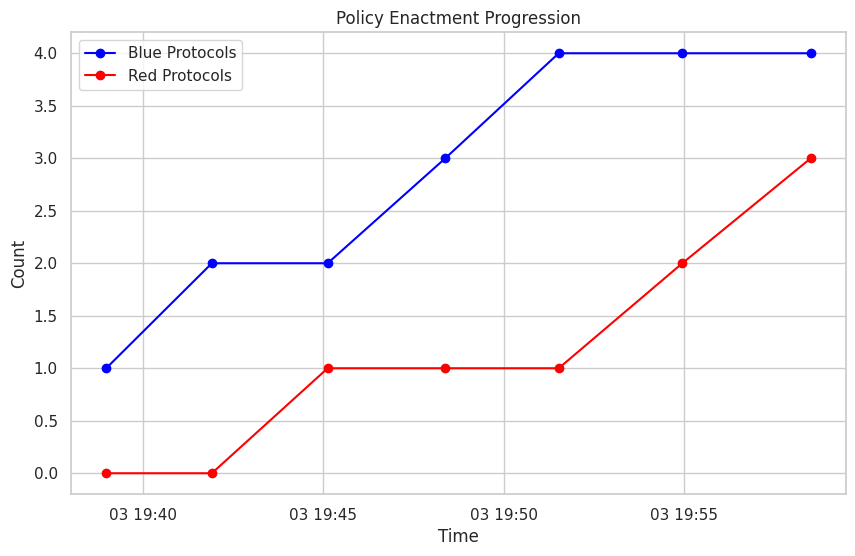

In [28]:
# Policy Progression
# Filter for enactment messages
# We look for game events with "Protocol has been enacted"
if 'event' in df.columns:
    enactments = df[(df['type'] == 'game_event') & (df['event'].str.contains("Protocol has been enacted", na=False))].copy()
    
    blue_count = 0
    red_count = 0
    policy_history = []
    
    for index, row in enactments.iterrows():
        event_text = row['event']
        if "Blue" in event_text:
            blue_count += 1
        elif "Red" in event_text:
            red_count += 1
        policy_history.append({'time': row['timestamp'], 'Blue': blue_count, 'Red': red_count})
    
    policy_df = pd.DataFrame(policy_history)
    
    if not policy_df.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(policy_df['time'], policy_df['Blue'], label='Blue Protocols', color='blue', marker='o', linestyle='-')
        plt.plot(policy_df['time'], policy_df['Red'], label='Red Protocols', color='red', marker='o', linestyle='-')
        plt.title('Policy Enactment Progression')
        plt.xlabel('Time')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No policies enacted yet.")
else:
    print("'event' column missing. Cannot track policy progression.")

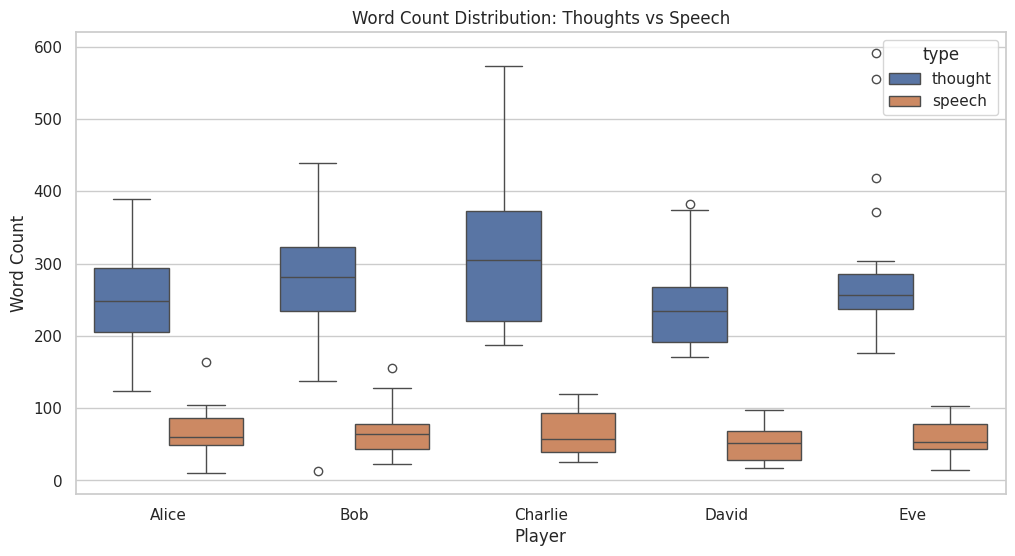


Average Word Counts by Role:
         role     type  word_count
0    Loyalist   speech   66.842105
1    Loyalist  thought  269.707317
2  Master Spy   speech   65.636364
3  Master Spy  thought  320.833333
4         Spy   speech   51.200000
5         Spy  thought  242.772727


In [29]:
# Communication Analysis
# Filter for relevant types
comm_df = df[df['type'].isin(['thought', 'speech'])].copy()

if not comm_df.empty:
    # Consolidate text content into one column
    comm_df['content'] = comm_df['thought'].fillna('') + comm_df['speech'].fillna('')
    
    # Calculate word counts
    comm_df['word_count'] = comm_df['content'].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=comm_df, x='player', y='word_count', hue='type')
    plt.title('Word Count Distribution: Thoughts vs Speech')
    plt.xlabel('Player')
    plt.ylabel('Word Count')
    plt.show()

    # Average word count by Role
    if 'role' in comm_df.columns:
        avg_words = comm_df.groupby(['role', 'type'])['word_count'].mean().reset_index()
        print("\nAverage Word Counts by Role:")
        print(avg_words)
    else:
        print("Role information not available for breakdown.")
else:
    print("No communication data found.")

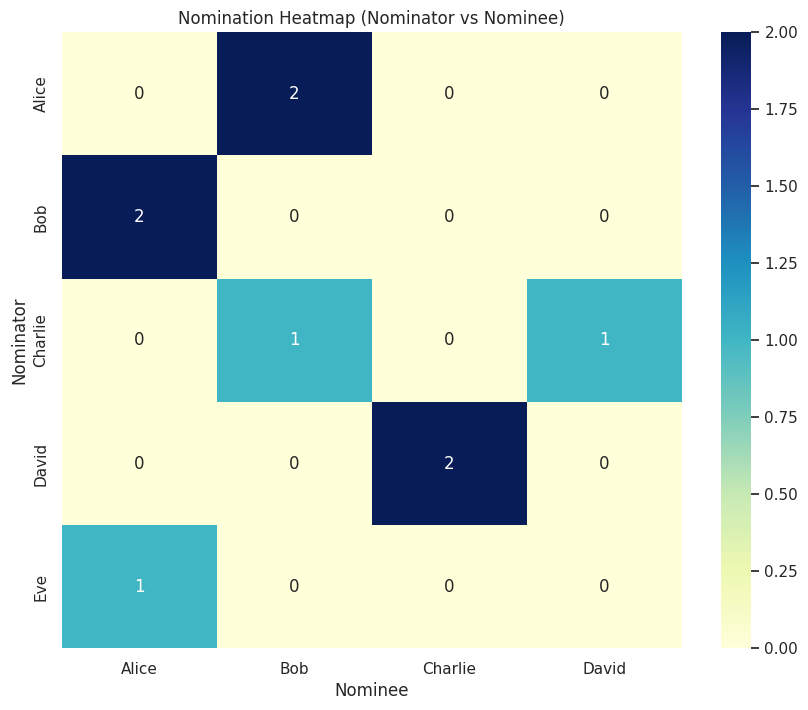

In [30]:
# Nomination Analysis
# Filter for nomination actions
if 'action' in df.columns and 'details' in df.columns:
    nominations_df = df[(df['type'] == 'action') & (df['action'] == 'Nominated')].copy()
    
    if not nominations_df.empty:
        # The nominee is in the 'details' column
        nominations_df['nominee'] = nominations_df['details']
        
        # Create a pivot table for nominations
        nomination_counts = nominations_df.groupby(['player', 'nominee']).size().unstack(fill_value=0)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(nomination_counts, annot=True, cmap='YlGnBu', fmt='d')
        plt.title('Nomination Heatmap (Nominator vs Nominee)')
        plt.xlabel('Nominee')
        plt.ylabel('Nominator')
        plt.show()
    else:
        print("No nomination data found.")
else:
    print("Critical columns (action, details) missing.")

/tmp/ipykernel_113410/2890003634.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rounds, x='round_num', y='duration_seconds', palette='viridis')


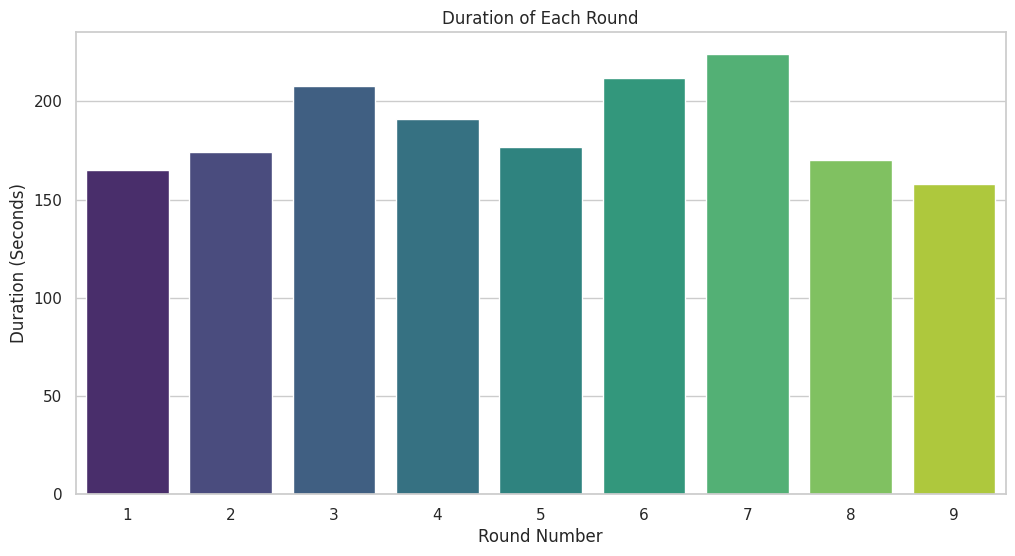

Average Round Duration: 186.56 seconds


In [35]:
# Turn Duration Analysis
# We can estimate turn duration by looking at the time difference between "Round X" messages.
# We look for system messages containing "--- Round"
if 'message' in df.columns:
    rounds = df[(df['type'] == 'system') & (df['message'].str.contains("--- Round", na=False))].copy()
    
    if not rounds.empty:
        rounds['round_num'] = rounds['message'].str.extract(r'Round (\d+)').astype(int)
        rounds = rounds.sort_values('timestamp')
        
        # Calculate duration of each round
        rounds['duration'] = rounds['timestamp'].diff().shift(-1)
        
        # The last round duration is until the end of the game
        if 'timestamp' in df.columns:
            end_time = df['timestamp'].max()
            rounds.iloc[-1, rounds.columns.get_loc('duration')] = end_time - rounds.iloc[-1]['timestamp']
        
        # Convert to seconds
        rounds['duration_seconds'] = rounds['duration'].dt.total_seconds()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=rounds, x='round_num', y='duration_seconds', palette='viridis')
        plt.title('Duration of Each Round')
        plt.xlabel('Round Number')
        plt.ylabel('Duration (Seconds)')
        plt.show()
        
        print(f"Average Round Duration: {rounds['duration_seconds'].mean():.2f} seconds")
    else:
        print("Could not extract round information.")
else:
    print("'message' column missing (or no system messages found).")

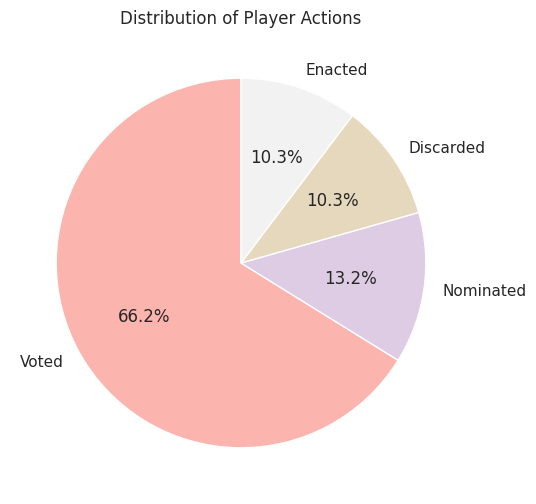

In [33]:
# Action Distribution
# Visualize the frequency of different action types
if 'action' in df.columns:
    # Filter for action types (exclude NaNs)
    action_counts = df[df['type'] == 'action']['action'].value_counts()
    
    if not action_counts.empty:
        plt.figure(figsize=(10, 6))
        action_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Pastel1')
        plt.title('Distribution of Player Actions')
        plt.ylabel('')
        plt.show()
    else:
        print("No actions found.")
else:
    print("'action' column missing.")